In [ ]:
# Import necessary libraries for data manipulation, machine learning, and plotting.
import os
import random
import math as m
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive to save the model.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define a function to set random seeds for reproducibility across different libraries.
def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
# Set the random seed and define the EarlyStopping class to prevent overfitting during training.
set_seed(seed=42)

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
# Define the NN_Plant class for neural network model creation, training, evaluation, and plotting.
class NN_Plant:
    def __init__(self, model=None):
        self.sequence_length = 150
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = 10500
        self.epochs = 500
        self.dataset_size = 336000
        self.data_file = 'https://raw.githubusercontent.com/RAI-Techno/ddmr_control/refs/heads/main/Data%20and%20Codes/Data.csv'
        self.model_file = '/content/drive/MyDrive/System_Identification_Model.pth'
        self.output_names = ["Wl", "Wr"]

        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

        if model is None:
            self.model = nn.Sequential(
                nn.Conv1d(in_channels= 2, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(64 * self.sequence_length, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 32),
                nn.ReLU(),
                nn.Linear(32, 2)
            )
        else:
            self.model = model

        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.loss_function = nn.SmoothL1Loss()
        self.metric_function = nn.MSELoss()
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", factor=0.85, patience=3, min_lr=1e-6)

    # Prepares the dataset by splitting it into training, validation, and test sets
    def prepare_dataset(self):
        data = pd.read_csv(self.data_file)
        features = data.iloc[:self.dataset_size, 1:3].values
        targets = data.iloc[:self.dataset_size, 3:5].values

        feature_sequences = []
        target_values = []

        zero_sequence = np.zeros((self.sequence_length, features.shape[1]))
        zero_target = np.zeros(targets.shape[1])
        feature_sequences.append(zero_sequence)
        target_values.append(zero_target)

        for i in range(len(features) - self.sequence_length + 1):
            feature_sequences.append(features[i : i + self.sequence_length])
            target_values.append(targets[i + self.sequence_length - 1])
        feature_array = np.array(feature_sequences)
        target_array = np.array(target_values)

        X_train, X_temp, y_train, y_temp = train_test_split(feature_array, target_array, train_size=0.6, shuffle=False)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.67, shuffle=False)

        self.train_loader = DataLoader(TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train)),
                                       batch_size=self.batch_size, shuffle=False)
        self.val_loader = DataLoader(TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val)),
                                     batch_size=self.batch_size, shuffle=False)
        self.test_loader = DataLoader(TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test)),
                                      batch_size=self.batch_size, shuffle=False)

    # Train the neural network model using the prepared dataset, including validation and early stopping.
    def train_model(self):
        training_history = {"loss": [], "mse": [], "val_loss": [], "val_mse": []}
        early_stopping = EarlyStopping(patience=10)

        for epoch in range(self.epochs):
            self.model.train()
            epoch_losses, epoch_metrics = [], []

            for features, targets in self.train_loader:
                features = features.to(self.device)
                targets = targets.to(self.device)
                features = features.permute(0, 2, 1)

                self.optimizer.zero_grad()
                predictions = self.model(features)
                loss = self.loss_function(predictions, targets)
                metric = self.metric_function(predictions, targets)

                loss.backward()
                self.optimizer.step()

                epoch_losses.append(loss.item())
                epoch_metrics.append(metric.item())


            self.model.eval()
            val_losses, val_metrics = [], []
            with torch.no_grad():
                for features, targets in self.val_loader:
                    features = features.to(self.device)
                    targets = targets.to(self.device)
                    features = features.permute(0, 2, 1)

                    predictions = self.model(features)
                    val_losses.append(self.loss_function(predictions, targets).item())
                    val_metrics.append(self.metric_function(predictions, targets).item())

            training_history["loss"].append(np.mean(epoch_losses))
            training_history["mse"].append(np.mean(epoch_metrics))
            training_history["val_loss"].append(np.mean(val_losses))
            training_history["val_mse"].append(np.mean(val_metrics))

            print(f"Epoch {epoch+1}/{self.epochs} | Loss: {training_history['loss'][-1]:.6f} | Val Loss: {training_history['val_loss'][-1]:.6f}")

            self.scheduler.step(training_history["val_loss"][-1])
            early_stopping(training_history["val_loss"][-1])

            if early_stopping.early_stop:
                break

        torch.save(self.model.state_dict(), self.model_file)
        return training_history

    # Evaluates the trained model on the test dataset and calculates various metrics like Huber error, MSE, and R-squared.
    def evaluate_model(self):
        self.model.eval()
        actual_values, predicted_values = [], []

        with torch.no_grad():
            for features, targets in self.test_loader:
                features = features.to(self.device)
                features = features.permute(0, 2, 1)
                predictions = self.model(features).cpu().numpy()
                predicted_values.append(predictions)
                actual_values.append(targets.numpy())

        predicted_array = np.vstack(predicted_values)
        actual_array = np.vstack(actual_values)

        huber_error = np.mean(np.abs(predicted_array - actual_array))
        mse_error = np.mean((predicted_array - actual_array)**2)

        print(f"Test Huber Error: {huber_error:.6f} | Test MSE: {mse_error:.6f}")

        r2_scores = [r2_score(actual_array[:, i], predicted_array[:, i]) for i in range(actual_array.shape[1])]
        for output_index, score in enumerate(r2_scores):
            print(f"R² Score Output {output_index+1}: {score:.4f}")
        average_r2 = np.mean(r2_scores)
        print(f"Average R²: {average_r2:.4f}\n")

        return actual_array, predicted_array, {"huber": huber_error, "mse": mse_error}, average_r2

    # Plots the training history (loss and MSE) and compares actual vs. predicted values from the evaluation.
    def plot_results(self, training_history, actual_values, predicted_values, samples=1000, fig1_size=(12,8), fig2_size=(12,8)):
        figure1, axes1 = plt.subplots(2, 1, figsize=fig1_size, sharex=True)

        axes1[0].plot(training_history["loss"], label="Training Huber Loss")
        axes1[0].plot(training_history["val_loss"], label="Validation Huber Loss")
        axes1[0].legend()
        axes1[0].grid(True)

        axes1[1].plot(training_history["mse"], label="Training MSE")
        axes1[1].plot(training_history["val_mse"], label="Validation MSE")
        axes1[1].legend()
        axes1[1].grid(True)
        axes1[1].set_xlabel("Epoch")
        plt.show()

        outputs_count = actual_values.shape[1]
        display_samples = min(samples, actual_values.shape[0])
        columns = min(outputs_count, 2)
        rows = m.ceil(outputs_count / columns)

        figure2, axes2 = plt.subplots(rows, columns, figsize=fig2_size, squeeze=False)
        output_labels = self.output_names if len(self.output_names) == outputs_count else [f"Output {i+1}" for i in range(outputs_count)]

        for output_index in range(outputs_count):
            row, col = divmod(output_index, columns)
            axes2[row][col].plot(range(display_samples), actual_values[:display_samples, output_index], label="Actual Values")
            axes2[row][col].plot(range(display_samples), predicted_values[:display_samples, output_index], '--', label="Predicted Values")
            axes2[row][col].set_title(output_labels[output_index])
            axes2[row][col].legend()
            axes2[row][col].grid(True)

        for empty_index in range(outputs_count, rows * columns):
            row, col = divmod(empty_index, columns)
            axes2[row][col].axis("off")

        plt.show()

    # Orchestrates the entire training process: prepares data, trains the model, evaluates it, and plots the results.
    def execute_training_process(self):
        self.prepare_dataset()
        training_history = self.train_model()
        actual_values, predicted_values, metrics, r2_score = self.evaluate_model()
        self.plot_results(training_history, actual_values, predicted_values)

Epoch 1/500 | Loss: 7.190186 | Val Loss: 2.980770
Epoch 2/500 | Loss: 2.536949 | Val Loss: 2.400576
Epoch 3/500 | Loss: 2.222195 | Val Loss: 2.229992
Epoch 4/500 | Loss: 1.919699 | Val Loss: 1.623526
Epoch 5/500 | Loss: 1.377607 | Val Loss: 1.365697
Epoch 6/500 | Loss: 1.218351 | Val Loss: 1.185641
Epoch 7/500 | Loss: 0.995989 | Val Loss: 1.131678
Epoch 8/500 | Loss: 1.026712 | Val Loss: 1.186963
Epoch 9/500 | Loss: 0.955926 | Val Loss: 0.861792
Epoch 10/500 | Loss: 0.758743 | Val Loss: 0.853787
Epoch 11/500 | Loss: 0.661871 | Val Loss: 0.727592
Epoch 12/500 | Loss: 0.834293 | Val Loss: 0.792684
Epoch 13/500 | Loss: 0.579895 | Val Loss: 0.624930
Epoch 14/500 | Loss: 0.599366 | Val Loss: 0.679930
Epoch 15/500 | Loss: 0.543294 | Val Loss: 0.691236
Epoch 16/500 | Loss: 0.507217 | Val Loss: 0.640757
Epoch 17/500 | Loss: 0.492607 | Val Loss: 0.600337
Epoch 18/500 | Loss: 0.479129 | Val Loss: 0.667500
Epoch 19/500 | Loss: 0.458419 | Val Loss: 0.635103
Epoch 20/500 | Loss: 0.444583 | Val Loss

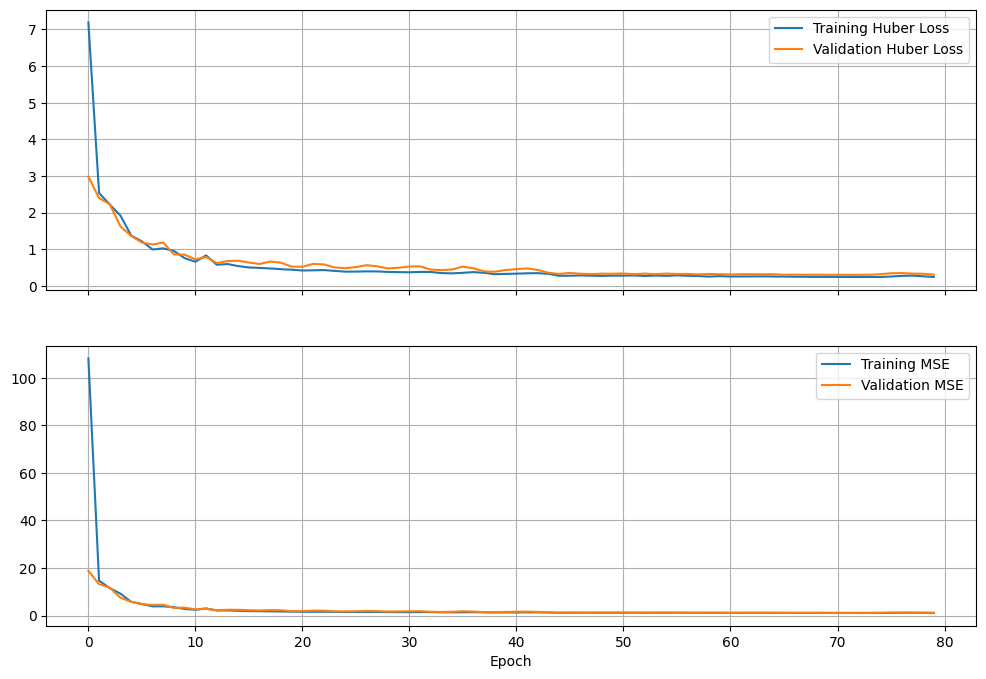

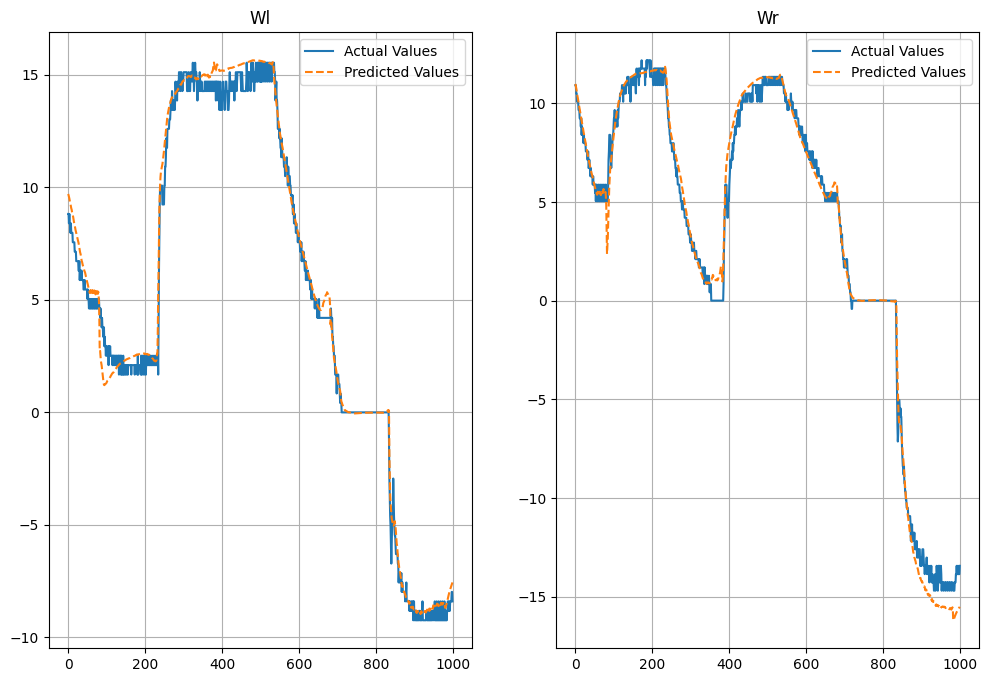

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Initialize the NN_Plant model, execute the training and evaluation process, then download the trained model.
plant = NN_Plant()
plant.execute_training_process()

path = plant.model_file
files.download(path)